# Web Agent

This is a vision-enabled web-browsing agent capable of controlling the mouse and keyboard. It is based on the web voyager from the following source code. Under the folder 'source-web-voyager' i have made a notebook of the source code if you are interested in the original. I have in this notebook built a newer version using the newest technology.

source code: https://langchain-ai.github.io/langgraph/tutorials/web-navigation/web_voyager/

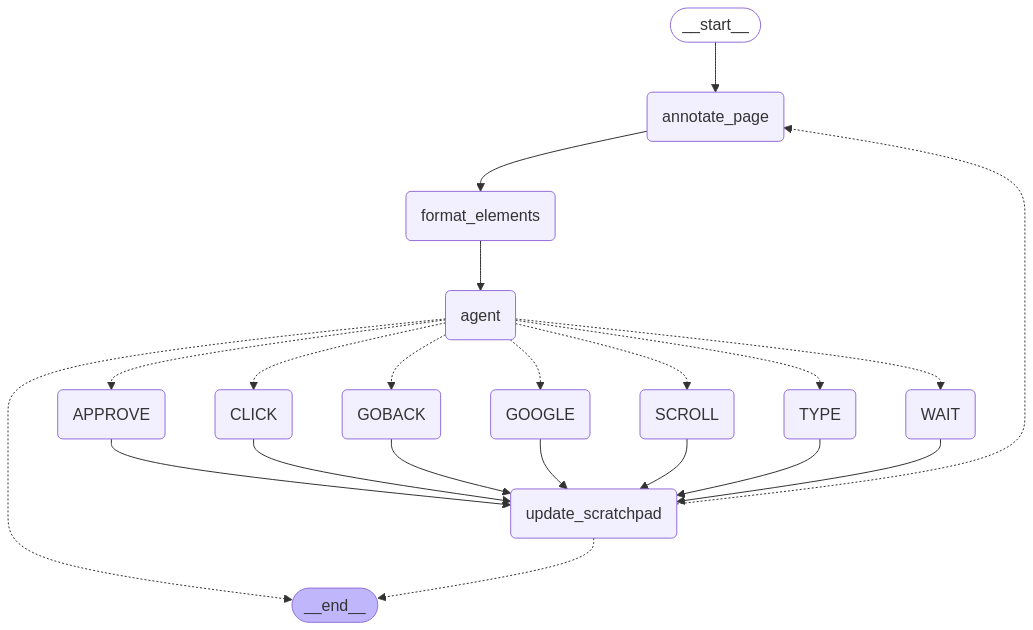

In [55]:
from IPython.display import display, Image

display(Image(filename='web-graph.png', width=600, unconfined=True))

# Setup Environment
Set up the environment by importing necessary libraries and setting up API keys.

In [56]:
# # Install required packages
# !pip install --quiet langgraph langsmith langchain_openai playwright nest_asyncio
# # Install Playwright browser
# !playwright install

# Import necessary libraries
import os
import nest_asyncio

from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Apply nest_asyncio for running async code in Jupyter
nest_asyncio.apply()

# Define A Helper File

Make sure to create a JS code file called mark_page.js in the same folder as the notebook

# Define Agent State
Define the `AgentState` class to represent the state of the agent, including the webpage, bounding boxes, and predictions.

In [57]:
from typing import List, Optional, Any, Dict, Literal
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from playwright.async_api import Page

# Define the BBox model
class BBox(BaseModel):
    """
    Represents a bounding box on the webpage with its coordinates and metadata.
    """
    x: float
    y: float
    text: str
    type: str
    ariaLabel: Optional[str] = None
    id: Optional[str] = None

    @property
    def description(self) -> str:
        """Generate a description for the bounding box."""
        label = self.ariaLabel or self.text or "No label"
        return f'{self.id} (<{self.type}/>): "{label}"'
    

# Define the Prediction model
class Prediction(BaseModel):
    """
    Represents the agent's predicted action and its arguments.
    """
    action: str = Field(description="The action to be performed by the agent")
    args: List[str] = Field(default_factory=list, description="Arguments for the action")

class Observation(BaseModel):
    """A single entry in the scratchpad"""
    step: int = 0
    action: str
    status: Literal["success", "warning", "error"]
    details: str
    
    def format(self) -> str:
        """Format the entry for display"""
        indicator = "✓" if self.status == "success" else "⚠️" if self.status == "warning" else "✗"
        return f"{self.step}. {indicator} {self.action.upper()}: {self.details}"


# Define the AgentState model
class AgentState(BaseModel):
    """
    Represents the state of the agent during execution.
    """
    testing: bool = Field(default=False, description="Flag indicating if the agent is in testing mode")
    test_actions: Optional[List[Prediction]] = Field(default=list, description="The action to be tested")
    page: Optional[Page] = Field(default=None, exclude=True)  # Non-serializable Playwright page object
    input: str = ""
    img: Optional[str] = ""
    bboxes: Optional[List[BBox]] = Field(default_factory=list, description="List of bounding boxes annotated on the webpage")
    prediction: Optional[Prediction] = Field(None, description="The agent's predicted action and arguments")
    scratchpad: Optional[List[BaseMessage]] = Field(default_factory=list, description="Intermediate steps or system messages")
    observation: Optional[str] = ""
    ids: Optional[List[int]] = Field(default_factory=list)
    observations: Optional[List[Observation]] = Field(default_factory=list, description="List of observations made by the agent")
    repeated_failures: Optional[int] = Field(default=0, description="Count of repeated failures for the current action")

    def add_observation(self, action: str, status: str, details: str) -> None:
        """Add a new observation to the history"""
        step = len(self.observations) + 1
        new_observation = Observation(step=step, action=action, status=status, details=details)
        self.observations.append(new_observation)
        self.observation = new_observation.format()  # Update the current observation string
        
    def check_repeated_failure(self, action: str, args: List[str]) -> Optional[List[Observation]]:
        """Check if this action+args combination has failed before"""
        if not self.observations:
            return None
            
        action_key = f"{action}:{','.join(args)}"
        failures = [
            obs for obs in self.observations 
            if obs.status == "error" and 
            f"{obs.action}:{','.join(args) if 'args' in obs.details else ''}" == action_key
        ]
        
        return failures if failures else None
    
    class Config:
        # Exclude the `page` attribute during serialization
        arbitrary_types_allowed = True
        json_encoders = {
            Page: lambda v: None,  # Prevent serialization of arbitrary objects
        }


class InputState(BaseModel):
    """
    Represents the input state of the agent.
    """
    testing: bool = Field(default=False, description="Flag indicating if the agent is in testing mode")
    input: str = Field(description="The input text provided to the agent")
    page: Optional[Page] = Field(default=None, exclude=True)  # Non-serializable Playwright page object
    test_actions: Optional[List[Prediction]] = Field(default=list, description="The action to be tested")

    class Config:
        # Exclude the `page` attribute during serialization
        arbitrary_types_allowed = True
        json_encoders = {
            Page: lambda v: None,  # Prevent serialization of arbitrary objects
        }

class OutputState(BaseModel):
    """
    Represents the output state of the agent.
    """
    img: Optional[str] = Field(description="Base64-encoded image of the webpage")
    bboxes: Optional[List[BBox]] = Field(default_factory=list, description="List of bounding boxes annotated on the webpage")
    prediction: Optional[Prediction] = Field(description="The agent's predicted action and arguments")
    scratchpad: Optional[List[BaseMessage]] = Field(default_factory=list, description="Intermediate steps or system messages")
    observation: Optional[str] = ""
    ids: Optional[List[int]] = Field(default_factory=list)

In [58]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Load the prompt template for the agent
#prompt = hub.pull("wfh/web-voyager")

# Define the structured output schema
class StrOutput(BaseModel):
    """
    Represents the structured output of the LLM.
    """
    thought: str = Field(..., description="Your brief thoughts (briefly summarize the info that will help ANSWER)")
    action: str = Field(..., description="The action you want to take")
    args: list[str] = Field(..., description="The arguments for the action")

# Initialize the LLM with gpt-4o and structured output
structured_llm = ChatOpenAI(model="gpt-4o").with_structured_output(schema=StrOutput)

# Define Tools
Implement the tools for the agent, such as 

1. `click`, 

2. `type_text`, 

3. `scroll`, 

4. `wait`,

5. `go_back`, 

5. `to_google`.

In [59]:
import asyncio
import platform
import functools
from typing import Callable, List, Dict, Any, Optional, Tuple, Union

# Constants
CLICK = "CLICK"
TYPE = "TYPE"
SCROLL = "SCROLL"
WAIT = "WAIT"
GOBACK = "GOBACK"
GOOGLE = "GOOGLE"
ANSWER = "ANSWER"
RETRY = "RETRY"
NAVIGATE = "NAVIGATE"

# Debug flag to enable detailed logging
DEBUG = True

# =============================================================================
# Utility Functions
# =============================================================================

def validate_args(state: AgentState, name: str, expected: int, args: List) -> bool:
    """Validate argument count for a tool"""
    if args is None or len(args) != expected:
        state.add_observation(
            name, 
            "error",
            f"Invalid arguments: expected {expected} argument(s), got {args}"
        )
        return False
    return True

def get_bbox(state: AgentState, name: str, bbox_id: int) -> Optional[Any]:
    """Get bounding box by ID with error handling"""
    try:
        bbox = state.bboxes[bbox_id]
        return bbox
    except IndexError:
        state.add_observation(
            name,
            "error",
            f"No bounding box found with ID {bbox_id}"
        )
        return None

async def handle_navigation(state: AgentState, page, action_func, success_message, name: str):
    """Handle possible navigation after an action with proper bounding box cleanup"""
    navigation_detected = False
    
    try:
        # Create a context manager for navigation events with a timeout
        async with page.expect_navigation(timeout=5000) as navigation_info:
            # Execute the provided action
            await action_func()
            # Wait for navigation to complete if it happens
            await navigation_info.value
            navigation_detected = True
    except Exception:
        # No navigation occurred or timeout reached
        print("No navigation")
        pass
        
    # Process the result based on whether navigation happened
    if navigation_detected:
        # Clear bounding boxes when navigation happens
        if DEBUG: print(f"🚀 Navigation detected - clearing bounding boxes")
        state.bboxes = []
        state.add_observation(name, "success", f"{success_message} and navigated to new page")
    else:
        # No navigation occurred
        state.add_observation(name, "success", success_message)
        
    # Give the page a moment to stabilize
    await asyncio.sleep(1)

# =============================================================================
# Enhanced Web Tool Decorator
# =============================================================================

def web_tool(func):
    """Decorator for web tools to handle common error patterns and observation recording"""
    @functools.wraps(func)
    async def wrapper(state: AgentState, config, name: str = None):
        tool_name = name if name else func.__name__.upper()
        try:
            # Execute the tool function - this should modify state in-place
            await func(state, config, tool_name)
            # Return the observation string, not the state object
            return state.observation
        except Exception as e:
            # Handle general exceptions
            state.add_observation(tool_name, "error", f"Exception: {str(e)}")
            print(f"Error in {func.__name__}: {e}")
            # Return the error observation as a string
            return state.observation
    return wrapper

# =============================================================================
# Navigation Tools
# =============================================================================

@web_tool
async def navigate_to(state: AgentState, config, name: str = "NAVIGATE"):
    """Directly navigates to a specified URL."""
    page = config["configurable"].get("page")
    nav_args = state.prediction.args
    
    if not validate_args(state, name, 1, nav_args):
        return
        
    url = nav_args[0]
    
    # Add https:// if not present
    if not url.startswith("http"):
        url = f"https://{url}"
    
    # Clear existing bounding boxes BEFORE navigation
    if DEBUG: print(f"🧹 Clearing bounding boxes before navigation to {url}")
    state.bboxes = []
    
    try:
        # Navigate to the URL
        await page.goto(url, wait_until="domcontentloaded", timeout=10000)
        
        # Wait for the page to be fully loaded
        try:
            await page.wait_for_load_state("networkidle", timeout=5000)
        except Exception as e:
            print(f"Network idle wait failed but continuing: {str(e)}")
        
        # Allow time for page to fully render
        await asyncio.sleep(2)
        
        state.add_observation(name, "success", f"Successfully navigated to {url}")
    except Exception as e:
        state.add_observation(name, "error", f"Navigation failed: {str(e)}")

@web_tool
async def go_back(state: AgentState, config, name: str = GOBACK):
    """Simulates navigating back to the previous page in the browser."""
    page = config["configurable"].get("page")
    
    # Clear existing bounding boxes BEFORE navigation
    if DEBUG: print(f"🧹 Clearing bounding boxes before going back")
    state.bboxes = []
    
    await page.go_back()
    current_url = page.url
    
    state.add_observation(name, "success", f"Navigated back to {current_url}")

@web_tool
async def to_google(state: AgentState, config, name: str = GOOGLE):
    """Simulates navigating to the Google homepage."""
    page = config["configurable"].get("page")
    
    # Clear existing bounding boxes BEFORE navigation
    if DEBUG: print(f"🧹 Clearing bounding boxes before going to Google")
    state.bboxes = []
    
    await page.goto("https://www.google.com/")
    
    state.add_observation(name, "success", "Navigated to Google homepage")

# =============================================================================
# Interaction Tools
# =============================================================================

@web_tool
async def click(state: AgentState, config, name: str = CLICK):
    """Simulates a mouse click on a bounding box identified by its label."""
    page = config["configurable"].get("page")
    click_args = state.prediction.args
    
    if not validate_args(state, name, 1, click_args):
        return
        
    bbox_id = int(click_args[0])
    bbox = get_bbox(state, name, bbox_id)
    if bbox is None:
        return
    
    element_text = bbox.text[:30] + "..." if len(bbox.text) > 30 else bbox.text
    success_message = f"Clicked element {bbox_id} ({bbox.type}: '{element_text}')"
    
    # Define the click action as a callable
    click_action = lambda: page.mouse.click(bbox.x, bbox.y)
    
    # Handle the click with navigation detection
    await handle_navigation(state, page, click_action, success_message, name)

@web_tool
async def type_text(state: AgentState, config, name: str = TYPE):
    """Simulates typing text into an input field identified by a bounding box label."""
    page = config["configurable"].get("page")
    type_args = state.prediction.args
    
    if not validate_args(state, name, 2, type_args):
        return
        
    bbox_id = int(type_args[0])
    text_content = type_args[1]
    
    bbox = get_bbox(state, name, bbox_id)
    if bbox is None:
        return
    
    async def type_action():
        x, y = bbox.x, bbox.y
        await page.mouse.click(x, y)
        select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
        await page.keyboard.press(select_all)
        await page.keyboard.press("Backspace")
        await page.keyboard.type(text_content)
        
        # Only press Enter if the text ends with newline
        if "\n" in text_content:
            await page.keyboard.press("Enter")
    
    safe_text = text_content[:15] + "..." if len(text_content) > 15 else text_content
    success_message = f"Text '{safe_text}' entered in element {bbox_id} ({bbox.type})"
    
    # Handle typing with navigation detection
    await handle_navigation(state, page, type_action, success_message, name)

@web_tool
async def scroll(state: AgentState, config, name: str = SCROLL):
    """Simulates scrolling within the webpage or a specific element."""
    page = config["configurable"].get("page")
    scroll_args = state.prediction.args
    
    if not validate_args(state, name, 2, scroll_args):
        return
        
    target, direction = scroll_args
    scroll_amount = 500 if target.upper() == "WINDOW" else 200
    scroll_direction = -scroll_amount if direction.lower() == "up" else scroll_amount

    # Handle window scrolling
    if target.upper() == "WINDOW":
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
        state.add_observation(name, "success", f"Window scrolled {direction.lower()}")
    else:
        # Handle element scrolling
        try:
            target_id = int(target)
            bbox = get_bbox(state, name, target_id)
            if bbox is None:
                return
                
            x, y = bbox.x, bbox.y
            await page.mouse.move(x, y)
            await page.mouse.wheel(0, scroll_direction)
            
            state.add_observation(
                name,
                "success",
                f"Element {target_id} ({bbox.type}) scrolled {direction.lower()}"
            )
        except ValueError:
            state.add_observation(
                name,
                "error",
                f"Invalid target: {target} is not 'WINDOW' or a valid box ID"
            )

# =============================================================================
# Utility Tools
# =============================================================================

@web_tool
async def wait(state: AgentState, config, name: str = WAIT):
    """Simulates a wait action for a fixed duration."""
    sleep_time = 2  # Reduced wait time for better responsiveness
    await asyncio.sleep(sleep_time)
    state.add_observation(name, "success", f"Waited for {sleep_time} seconds")

# Define Browser Annotations
Define the `mark_page` function to annotate the browser page with bounding boxes for the agent to interact with.

# Define Agent
Compose the agent using the annotation function, prompt, LLM, and output parser.

In [60]:
import base64
from langchain_core.runnables import chain as chain_decorator
from langchain_core.runnables.config import RunnableConfig

path = "mark_page.js"
#path = os.path.join("source-web-voyager", "original_mark_page.js")

# Load the JavaScript code for annotating the page
with open(path) as f:
    # Some JavaScript we will run on each step
    # to take a screenshot of the page, select the
    # elements to annotate, and add bounding boxes
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    """
    Annotates the current browser page with bounding boxes for interactive elements,
    including elements inside iframes.
    """
    try:
        # DOM should definitely be loaded
        await page.wait_for_load_state("domcontentloaded")
        
        # Add a small delay to ensure JS has initialized
        await asyncio.sleep(1)
        
        # Now try to execute the JavaScript
        try:
            # Execute the JavaScript code to annotate the page
            await page.evaluate(mark_page_script)
        except Exception as e:
            print(f"Failed to evaluate mark_page_script: {e}")
            # Wait a bit and try again once
            await asyncio.sleep(2)
            await page.evaluate(mark_page_script)
            
        # Get the bounding boxes with retries
        bboxes = None
        for attempt in range(3):  # Reduced retry count but with better handling
            try:
                bboxes = await page.evaluate("markPage()")
                if bboxes:  # If we got valid data, break
                    break
                await asyncio.sleep(1)
            except Exception as e:
                print(f"Attempt {attempt+1}: Error getting bounding boxes: {e}")
                await asyncio.sleep(2)  # Wait longer between retries
    
        # Take a screenshot of the page
        screenshot = await page.screenshot()
        
        return {
            "img": base64.b64encode(screenshot).decode(),
            "bboxes": bboxes,
        }
    except Exception as e:
        print(f"Critical error in mark_page: {e}")
        # Return minimal valid data instead of raising
        return {
            "img": "",
            "bboxes": []
        }

async def annotate(state: AgentState, config):
    """
    Annotates the current page and processes bounding boxes for both the main page and iframes.
    """
    try:
        page = config["configurable"].get("page")
        
        # Debug the URL we're annotating
        if DEBUG: print(f"📝 Annotating page: {page.url}")
        
        # Annotate the page and get bounding boxes
        marked_page = await mark_page.with_retry().ainvoke(page)
        if DEBUG: print(f"✅ Found {len(marked_page['bboxes'])} bounding boxes")

        # Set the annotated image and bounding boxes in the state
        state.img = marked_page["img"]
        state.bboxes = [
            BBox(**bbox) for bbox in marked_page["bboxes"]
        ]  # Convert bounding boxes to BBox objects

        # Check if any bounding box is of type 'iframe'
        iframe_bboxes = [bbox for bbox in marked_page["bboxes"] if bbox["type"] == "iframe"]
        for iframe_bbox in iframe_bboxes:
            src = iframe_bbox.get("src")
            if not src:
                print(f"Skipping iframe with no src: {iframe_bbox}")
                continue

            print(f"Iframe detected with src: {src}. Processing iframe...")
            try:
                # Use 'page' from config, not state.page
                iframe = await page.frame_locator(f"iframe[src='{src}']").frame()
                iframe_marked_page = await mark_page.with_retry().ainvoke(iframe)
                print(f"Found {len(iframe_marked_page['bboxes'])} iframe bounding boxes")

                # Combine iframe bounding boxes with the main page bounding boxes
                state.bboxes.extend([
                    BBox(**bbox) for bbox in iframe_marked_page["bboxes"]
                ])
            except Exception as iframe_error:
                print(f"Error processing iframe with src {src}: {iframe_error}")

    except Exception as e:
        print(f"Error in annotate: {e}")
        raise

    return state

In [61]:
from typing import Dict

#Dropping the format instructions in this system message 
# to avoid formatting issues with the structured output

def agent_routes(routes: Dict[str, str]) -> str:
    actions = ''.join([f"- {key}: {value} \n" for key, value in routes.items()])
    text = f"""
    Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. 
    In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. 
    This screenshot will feature Numerical Labels placed in the TOP LEFT corner of each Web Element. 
    Carefully analyze the visual information to identify the Numerical Label corresponding to the Web Element 
    that requires interaction, then follow the guidelines and choose one of the following actions:
    
    {actions}
    
    Key Guidelines You MUST follow:
    
    * Action guidelines *
    1) Execute only one action per iteration.
    2) When clicking or typing, ensure to select the correct bounding box.
    3) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are colored the same.
    4) If you encounter a cookie consent popup (e.g., "Godta alle"), click on it to proceed. Use scroll if the labels in the bottom are not visible."
    
    * Web Browsing Guidelines *
    1) Don't interact with useless web elements like Login, Sign-in, donation that appear in Webpages
    2) Select strategically to minimize time wasted.
    
    Then the User will provide:
    Observation: A labeled screenshot Given by User

    If you encounter errors, please respond with "Error: [error message]".
    If you are unsure about the next action, respond with "I don't know what to do next".
    If you are unable to find the bounding box, respond with "Error: no bounding box for label [label]".
    If you encounter diffulties to find elements, use scroll to make them visible.

    """
    return text

# Define the routes
routes = {
    CLICK: "Click a Web Element. [Numerical_Label].",
    TYPE: "Delete existing content in a textbox and then type content. [Numerical_Label]; [Content].",
    SCROLL: "Scroll up or down. [Numerical_Label or WINDOW]; [up or down]. Usr this to make elements visible. Use this if stuck",
    WAIT: "Wait.",
    GOBACK: "Go back.",
    GOOGLE: "Return to Google to start over.",
    ANSWER: "Respond with the final answer. [Content]. or if you are stuck with the same observation three times, answer with the last observation.",
    RETRY: "Retry the last action.",
}

from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
)


input_prompt = {"type": "text", "text": "{input}"}

bbox_prompt = {"type": "text", "text": "{bbox_descriptions}"}

img_prompt = {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{img}"},
                }

new_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", agent_routes(routes=routes)),
         MessagesPlaceholder("scratchpad", optional=True),
        ("human", [input_prompt]),
        ("human", [bbox_prompt]),
        ("human", [img_prompt]),
    ]
)

In [62]:
from langchain_core.messages import BaseMessage, SystemMessage
import base64
import asyncio


def format_elements(state: AgentState) -> AgentState:
    """
    Formats the bounding box descriptions for the agent's prompt and updates the scratchpad.
    """
    # Create descriptions of available elements
    if state.bboxes:
        descriptions = [f"{i}: {bbox.description}" for i, bbox in enumerate(state.bboxes)]
        details = "\n".join(descriptions)
        message_content = f"Available elements on page:\n{details}"
    else:
        message_content = "No elements detected on page"
    
    # Create a standard SystemMessage that the LLM can understand
    bbox_message = SystemMessage(content=message_content)
    state.scratchpad.append(bbox_message)
    
    return state

# Main agent function
async def agent(state: AgentState, config) -> AgentState:
    """
    Main function to run the agent.
    """
    try:
        if state.testing:
            # For testing, we can use a mock prediction
            prediction = state.test_actions[0]
            print("Mock Prediction: ", prediction)

        else:
            # Step 1: Generate the prompt text
            prompt_text = new_prompt.invoke({
                "bbox_descriptions": state.bboxes,
                "img": state.img,  # Correctly embed the Base64-encoded image
                "input": state.input,
                "scratchpad": state.scratchpad,
            })
            # Step 2: Get the LLM response
            response = await structured_llm.ainvoke(prompt_text)
            prediction = Prediction(action=response.action, args=response.args)
            print("Prediction: ", prediction)
        # Step 3: Update the agent state with the prediction
        state.prediction = prediction

        return state

    except Exception as e:
        print(f"Error in agent function: {e}")
        raise


async def update_scratchpad(state: AgentState, config) -> AgentState:
    """
    Updates scratchpad with:
    1. Current observation at the top
    2. Any warnings immediately after
    3. Previous observations in reverse chronological order
    """
    try:
        page = config["configurable"].get("page")
        await page.evaluate("unmarkPage()")
    except Exception as e:
        print(f"Warning: Failed to unmark page: {e}")

    # Start with an empty scratchpad
    state.scratchpad = []
    
    # 1. First add current observation
    current_observation = state.observation
    current_msg = SystemMessage(content=f"CURRENT OBSERVATION:\n{current_observation}")
    state.scratchpad.append(current_msg)
    
    # 2. Add warning for repeated failures if needed (right after current observation)
    if state.prediction:
        repeated_failures = state.check_repeated_failure(
            state.prediction.action, 
            state.prediction.args
        )
        if repeated_failures:
            repeated_count = len(repeated_failures)
            state.repeated_failures = repeated_count
            warning_msg = (
                f"⚠️ WARNING: This exact action has failed {repeated_count} "
                f"times before. Consider an alternative approach."
            )
            state.scratchpad.append(SystemMessage(content=warning_msg))
        # If we are in testing mode, remove the first test action
        if state.testing:
            state.test_actions.pop(0)
    # 3. Add history message if we have previous observations
    if state.observations and len(state.observations) > 1:
        # Get all previous observations (excluding the current one)
        previous_observations = state.observations[:-1]
        
        # Format in reverse chronological order (newest first)
        history_content = "PREVIOUS OBSERVATIONS (newest first):\n"
        for obs in reversed(previous_observations):
            history_content += obs.format() + "\n"
        
        history_msg = SystemMessage(content=history_content)
        state.scratchpad.append(history_msg)
    
    return state

from langgraph.types import interrupt, Command

async def human_input(state: AgentState, config) -> AgentState:
    """
    Conditionally interrupts the graph for human approval based on state.
    """

    # Create a descriptive message about what's happening
    test_action = state.test_actions[0]
    action = test_action.action
    args = test_action.args
    # Format the message for user interaction
    message = f"Agent wants to perform: {action} with args: {args}"
    
    # This will pause execution and return the message to the client
    user_input = interrupt(message)
    
    # When execution resumes, user_input will contain the value
    # passed via Command(resume=...)
    print(f"User input: {user_input}")
    if user_input is not None:
        if user_input == '':
            # If user just pressed Enter, keep the original action and args
            # No changes needed to state.test_actions[0]
            pass
        else:
            # Only update if the user provided alternative input
            # Convert the input to a list to maintain proper args format
            new_args = [user_input]
            state.test_actions[0] = Prediction(action=action, args=new_args)

    return state

# Compile the Graph
Compile the agent's graph by defining nodes, edges, and conditional logic for tool selection.

In [63]:
from IPython.display import display, Image
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from typing import Literal

AGENT = "agent"
HUMAN_INTERACTION = "human_interaction"
FORMAT_ELEMENTS = "format_elements"
ANNOTATE_PAGE = "annotate_page"
UPDATE_SCRATCHPAD = "update_scratchpad"

builder = StateGraph(AgentState, input=InputState, output=OutputState)

builder.add_node(AGENT, agent)
builder.add_node(ANNOTATE_PAGE, annotate)
builder.add_node(FORMAT_ELEMENTS, format_elements)
builder.add_node(UPDATE_SCRATCHPAD, update_scratchpad)
builder.add_node(HUMAN_INTERACTION, human_input)

builder.add_edge(START, ANNOTATE_PAGE)
builder.add_edge(ANNOTATE_PAGE, FORMAT_ELEMENTS)

def after_annotate(state: AgentState) -> Literal[AGENT, END, HUMAN_INTERACTION]:
    """
    After annotating the page, we need to update the scratchpad and return to the agent.
    """
    if state.testing:
        if len(state.test_actions) == 0:
            # If there are no more test actions, end the process
            print("No more test actions left.")
            return END

    if state.repeated_failures > 1:
        # If we have repeated failures, return to the agent
        print("Repeated failures detected, ending the process.")
        return END
    
    # If we are in testing mode, we need to ask for human input
    print("Asking for human input...")
    return HUMAN_INTERACTION
    #return AGENT

builder.add_conditional_edges(
    FORMAT_ELEMENTS,
    after_annotate
)

builder.add_edge(
    HUMAN_INTERACTION,
    AGENT,
)

tools = {
    CLICK: click,
    TYPE: type_text,
    SCROLL: scroll,
    WAIT: wait,
    GOBACK: go_back,
    GOOGLE: to_google,
    NAVIGATE: navigate_to,
}

# Add tool nodes to the graph
for node_name, tool_func in tools.items():
    builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool_func) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    builder.add_edge(node_name, UPDATE_SCRATCHPAD)


nodes = Literal[
    CLICK,
    TYPE,
    SCROLL,
    WAIT,
    GOBACK,
    GOOGLE,
    NAVIGATE,
    END,
]

# Here we select the next option or we return to the user
def select_tool(state: AgentState) -> nodes:
    action = state.prediction.action
    if action == ANSWER:
        return END
    if action == RETRY:
        print("Retrying...")
        return AGENT
    return action

builder.add_conditional_edges(AGENT, select_tool)

def after_update_scratchpad(state: AgentState) -> Literal[END, ANNOTATE_PAGE]:
    """
    After updating the scratchpad
    """
    if state.repeated_failures > 1 or len(state.test_actions) == 0:
        # If we have repeated failures, return to the agent
        return END
    # Otherwise, continue with the next step
    return ANNOTATE_PAGE


builder.add_edge(UPDATE_SCRATCHPAD, ANNOTATE_PAGE)

# Create custom memory saver and compile the graph
memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    )

print(graph.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	annotate_page(annotate_page)
	format_elements(format_elements)
	update_scratchpad(update_scratchpad)
	human_interaction(human_interaction)
	CLICK(CLICK)
	TYPE(TYPE)
	SCROLL(SCROLL)
	WAIT(WAIT)
	GOBACK(GOBACK)
	GOOGLE(GOOGLE)
	NAVIGATE(NAVIGATE)
	__end__([<p>__end__</p>]):::last
	CLICK --> update_scratchpad;
	GOBACK --> update_scratchpad;
	GOOGLE --> update_scratchpad;
	NAVIGATE --> update_scratchpad;
	SCROLL --> update_scratchpad;
	TYPE --> update_scratchpad;
	WAIT --> update_scratchpad;
	__start__ --> annotate_page;
	annotate_page --> format_elements;
	human_interaction --> agent;
	update_scratchpad --> annotate_page;
	format_elements -.-> agent;
	format_elements -.-> __end__;
	format_elements -.-> human_interaction;
	agent -.-> CLICK;
	agent -.-> TYPE;
	agent -.-> SCROLL;
	agent -.-> WAIT;
	agent -.-> GOBACK;
	agent -.-> GOOGLE;
	agent -.-> NAVIGATE;
	agent -.-> __end__;
	cl

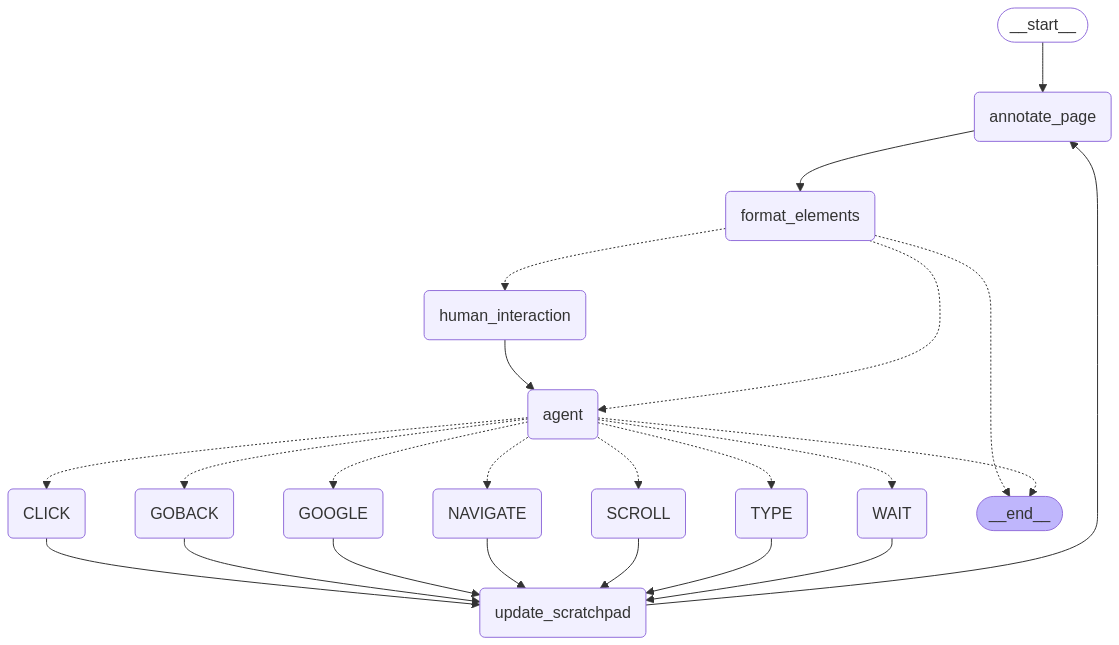

In [64]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [65]:
from IPython import display
import ipywidgets as widgets
from playwright.async_api import async_playwright
import asyncio
import uuid
import base64
import os
import shutil
from langchain_core.messages import ToolMessage


# Function to set up and manage history folder
def setup_history_folder():
    """Create or recreate the history folder"""
    history_dir = os.path.join(os.getcwd(), "history")
    if os.path.exists(history_dir):
        shutil.rmtree(history_dir)  # Delete existing folder
    os.makedirs(history_dir)  # Create empty folder
    return history_dir

# Function to save images to history folder
def save_image_to_history(image_data, filename="webpage.png", step=None):
    """Save an image to the history folder with optional step number in filename"""
    history_dir = os.path.join(os.getcwd(), "history")
    
    # Create folder if it doesn't exist
    if not os.path.exists(history_dir):
        os.makedirs(history_dir)
    
    # Add step number to filename if provided
    if step is not None:
        base_name, ext = os.path.splitext(filename)
        filename = f"{base_name}_{step}{ext}"
    
    # Save the image
    image_path = os.path.join(history_dir, filename)
    with open(image_path, "wb") as f:
        f.write(base64.b64decode(image_data))
    
    return image_path

# Create a persistent directory for the user data
user_data_dir = os.path.join(os.path.expanduser("~"), "playwright_user_data")
os.makedirs(user_data_dir, exist_ok=True)


# Set up a solution where we can update the image separately from the text
async def test_agent(config, query: str, testing: bool = False, test_actions: list = None) -> str:
    # Setup history folder at the start of the run
    history_dir = setup_history_folder()
    
    # Start Playwright
    playwright = await async_playwright().start()
    context = await playwright.chromium.launch_persistent_context(
        user_data_dir=user_data_dir,
        headless=False,
    )

    # Get the default page
    page = context.pages[0]
    
    # Navigate to Google
    _ = await page.goto("https://www.google.com")

    if testing:
        # Create a list of test actions
        predictions = [
            Prediction(action=action, args=args)
            for action, args in test_actions
        ]
    
    # Create an initial AgentState
    state = InputState(
        input=query, 
        testing=testing,
        test_actions=predictions if testing else None,
    )

    config["configurable"]["page"] = page
    try:
        final_answer = None
        steps = []
        
        # Initial graph input
        current_input = state
        
        while True:
            event_stream = graph.astream(current_input, config=config)
            
            # Reset current_input for next potential interrupt
            current_input = None
            stream_finished = False
            answer_found = False
            
            try:
                async for event in event_stream:
                    # Only clear output when it's NOT an interrupt event
                    if "__interrupt__" not in event:
                        display.clear_output(wait=True)            
                    
                    # Check if there's an interrupt in the event
                    if "__interrupt__" in event:
                        interrupt_info = event["__interrupt__"][0]
                        message = interrupt_info.value
                        
                        print("\n" + "=" * 50)
                        print(f"🔔 HUMAN INPUT REQUIRED:")
                        print(f"Agent is requesting approval: {message}")
                        print("=" * 50 + "\n")
                        
                        # Small delay to ensure message is visible before the input prompt appears
                        await asyncio.sleep(0.2)
                        
                        user_input = input(
                            f"""
                            Agent is requesting approval: {message}
                            \nClick 'ENTER' to approve or provide alternative instructions, pass the element id you want to invoke: """
                            )
                                     
                        # Create a Command to resume execution
                        current_input = Command(resume=user_input)
                        break  # Exit the event loop to process the command
                    
                    # Process normal event updates
                    step_number = len(steps)
                    if "format_elements" in event:
                        image = event["format_elements"]["img"]
                        # Update only the image using the display ID
                        display.display(display.Image(base64.b64decode(image)))
                        # Save image with step number
                        save_image_to_history(image, "webpage.png", step_number)

                    if "agent" in event:
                        pred = event["agent"].get("prediction") or {}
                        action = pred.action if hasattr(pred, "action") else None
                        action_input = pred.args if hasattr(pred, "args") else None
                        
                        if action:
                            # Add to steps and display updated text
                            steps.append(f"{len(steps) + 1}. {action}: {action_input}")
                            print(f"\n--- Agent Event ---")
                            print(f"Action: {action}")
                            print(f"Action Input: {action_input}")
                            print("\n".join(steps))
                            
                            if action == "ANSWER":
                                # Save final screenshot with special name
                                if "format_elements" in event and "img" in event["format_elements"]:
                                    save_image_to_history(event["format_elements"]["img"], "final_webpage.png")
                                print(f"\nFinal answer: {action_input[0]}")
                                final_answer = action_input[0]
                                answer_found = True
                                break
                
                # If we've processed all events without interruption or finding an answer
                stream_finished = True
                
            except Exception as e:
                print(f"Error during stream processing: {e}")
                break  # Exit on error
            
            # If we found an answer, we're done
            if answer_found:
                break
                
            # If the stream finished normally (no interrupts) and we don't have new input to process, we're done
            if stream_finished and not current_input:
                # Check if we need to continue due to state of the graph
                state = graph.get_state(config)
                if not state or not hasattr(state, 'test_actions') or not state.test_actions:
                    print("No more actions to test, finishing.")
                    break
                    
                # If we got here, keep processing the next cycle without user interaction
                print("Continuing to next test action automatically.")
                continue
                
            # If we have a command to process, continue the loop; otherwise exit
            if not current_input:
                print("Processing complete - no more actions to take.")
                break
                
        print("Agent execution completed successfully.")
        print(f"All screenshots saved to: {history_dir}")
        
    finally:
        # Clean up resources
        await context.close()
        await playwright.stop()
        
    return final_answer

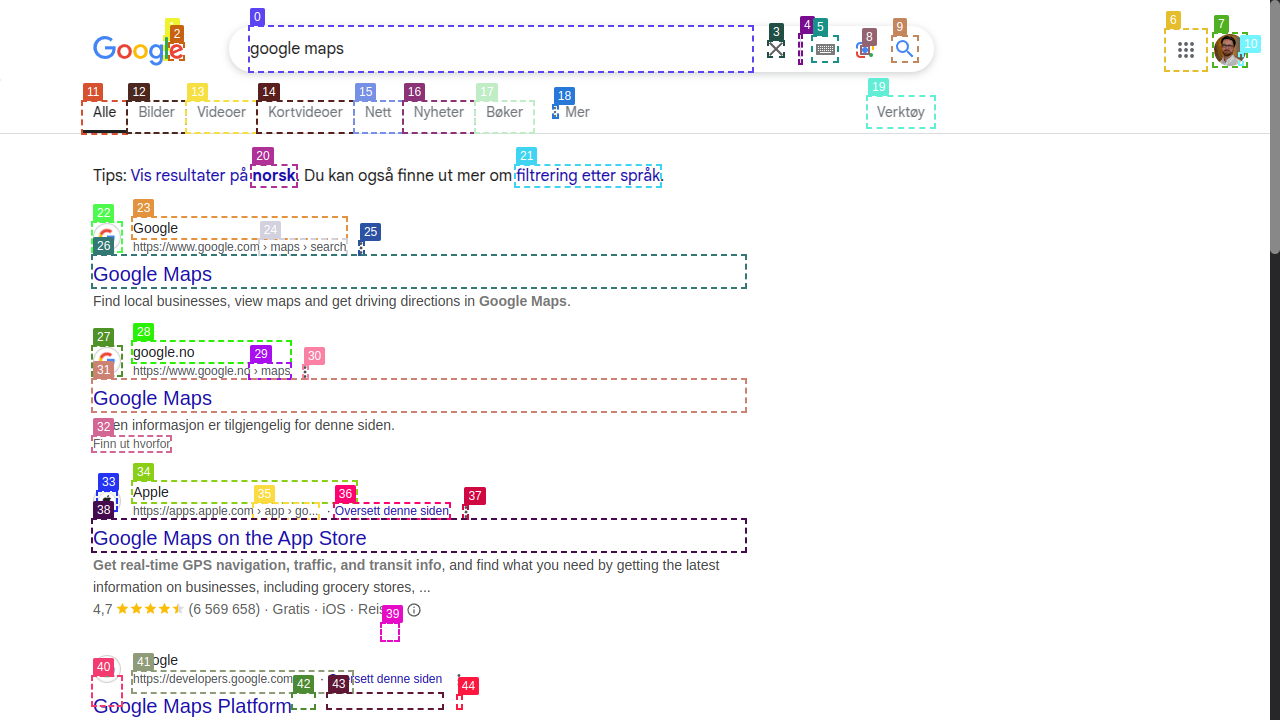

No more actions to test, finishing.
Agent execution completed successfully.
All screenshots saved to: /home/teodorrk/projects/cogitoxinfor-agents/teodor/langgraph/notebooks/web-agent/history


In [66]:
instructions = """ 
1. When pop box with  (<a/>): "informasjonskapsler" pops up. Use scroll to make it visible and click on "godta alle"
2. If you see (<a/>): "Godta alle" click on it to accept cookies.
3. Go to finn.no
3. In finn.no find the Search and search for 'BMW iX xDrive40 2022'.
4. Click on the car.
5. Find the car's specifications.
6. Give me a summary of the car's specifications and features.
"""

# Define the sequence of actions to test
test_actions = [
    (CLICK, ['6']), 
    (TYPE, ['6', 'google maps']), 
    #(WAIT, ['6']),
    (CLICK, ['21']),             
    #(WAIT, ['2']),                
    #(CLICK, ['27']),
    #(WAIT, ['2']),
    #(CLICK, ['2']),               
    #(TYPE, ['2', 'BMW iX xDrive40 2022']),                  

    # Continue with other actions...
]

#test_actions = [
#    (NAVIGATE, ['https://www.finn.no']),  
#]

config = {
"recursion_limit": 150,
"configurable": {
    "thread_id": str(uuid.uuid4()),
}
}


# Run the test
res = await test_agent(
config=config,
query=instructions,
testing=True,
test_actions=test_actions,
)

In [67]:
values = graph.get_state(config=config)
values

StateSnapshot(values={'testing': True, 'test_actions': [], 'input': ' \n1. When pop box with  (<a/>): "informasjonskapsler" pops up. Use scroll to make it visible and click on "godta alle"\n2. If you see (<a/>): "Godta alle" click on it to accept cookies.\n3. Go to finn.no\n3. In finn.no find the Search and search for \'BMW iX xDrive40 2022\'.\n4. Click on the car.\n5. Find the car\'s specifications.\n6. Give me a summary of the car\'s specifications and features.\n', 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xdgk3X+B/DPM5InSdukewClBcqQCoUiKAiyFHqAFDyonEBRRH+H4ClDBRwcLkDBgQKeIB4FPEROKIIHuBgKyCi0yJIWuuheSZvxJM/4/fGkaUhX2qZNx+flevLMb0HyPO/nuwhRFAEhhBBCCCGEEGr7+vSJBIDu3bv17t0rIMAfAAoLi27c+PPWrdsAQLu7eAghhBBCCCGEkMsMHnzfvff2tX0MDg4KDg7y8/M7d+48BmCEEEIIIYQQQu1E9+7d7NOvzb339i0uLibdUSSEEEIIIYQQQsj1evfuVccmDMAIIYQQQgghhNoJqd9vbZswACOEEEIIIYQQaicoiqpjEwZghBBCCCGEEEIdAgZghBBCCCGEEEIdAo4CjTqQE0csu7eYy7X1zH3tpSFmPCN/aLyspcqFEEIIIYQQaglYA4w6EGfSLwCUa8XdW8w

In [68]:
# all_states = []
# for state in graph.get_state_history(config):
#     print(state)
#     all_states.append(state)
#     print("--")

# Compile the Graph
Compile the agent's graph by defining nodes, edges, and conditional logic for tool selection.